**Librerías**

In [144]:
import pandas as pd
import numpy as np
from pycaret.classification import *
import sklearn
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
import seaborn as sns
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import GridSearchCV

print('Librerías cargadas')

Librerías cargadas


****Lectura de ficheros.****

Creamos una función para leer todos los ficheros que están en la ruta, vamos a leer los ficheros llamados 'training'

In [145]:
libros = os.listdir('./') # leer el nombre de todos los ficheros que están en la ruta.
libros_objetivos = [] # Lista para incluir el nombre de los ficheros que queremos leer.

for i in libros:
    if i[0:4] == 'trai':
        libros_objetivos.append(i)

In [146]:
# Creamos un diccionario para incluir los ficheros de la X y de la y

diccionario_libros = {}

for i in libros_objetivos:
    df = pd.read_csv(i)
    diccionario_libros[i] = [df, df.shape]

Comrprobamos el tamaño de cada uno de los libros y comprobamos que ambos libros tienen al menos el mismo número de registros.

In [147]:
for i in diccionario_libros.keys():
    
    print(f'el libro {i} tiene un tamaño de; {diccionario_libros[i][1]}')

el libro training_y_.csv tiene un tamaño de; (59400, 2)
el libro training_x_.csv tiene un tamaño de; (59400, 40)


Se unifican ambos libros para que estén en el mismo orden y se comprueba que sigan teniendo el mismo número de registros (59.400).

In [148]:
df_completo = pd.merge(left=diccionario_libros['training_x_.csv'][0], right=diccionario_libros['training_y_.csv'][0], on='id').drop_duplicates()
df_completo.shape[0]

59400

Añadir el fichero de predicciónes para hacerle el mismo preprocesado.

In [149]:
# Lectura del libro sobre el que se van a hacer predicciones.

libro_objetivo = []
for i in libros:
    if i[0:4] == 'test':
        libro_objetivo.append(i)

df_prediccion_ = pd.read_csv('./'+libro_objetivo[0])

# Añadir la columna objetivos sobre el df de predicciones 'status_group'

df_prediccion_['status_group'] = 'pendiente'
df.shape

(59400, 40)

Unión de todo el dataframe y copia antes del preprocesado.

In [150]:
df_completo = pd.concat([df_completo, df_prediccion_])

df_completo_sin_manipular = df_completo

## **LIMPIEZA DATASET**

**búsqueda de missings**

In [151]:
# Función para ver el número de missings.

def missing_checks(df):
    contador = 0
    n_index = []
    valores = []

    for i in df.columns:

        n_index.append(i)
        a = (df.apply(lambda x: x.isna().sum()/x.count()*100)[contador])
        valores.append(a)
        contador = contador + 1

    # Muestra de columnas por missing

    df_missing = pd.DataFrame(valores,columns=['% MISSING'],index=n_index)
    df_missing = df_missing[df_missing['% MISSING']>0]
    salida = df_missing.sort_values(by='% MISSING',ascending=False)
    return salida

En primer lugar vamos a hacer un estado de situación sobre el número de missings.

In [152]:

df_missings = missing_checks(df_completo)
df_missings

,% MISSING
scheme_name,90.423677
scheme_management,6.982306
installer,6.500473
funder,6.457718
public_meeting,5.927670
permit,5.383425
subvillage,0.637029


In [153]:
# 1. El primero 'scheme name' y el segundo 'scheme_management' (who operates the waterpoint) se va a imputar como unkown.

df_completo['scheme_name'] = df_completo['scheme_name'].fillna('unkown')
df_completo['scheme_management'] = df_completo['scheme_management'].fillna('unkown')

In [154]:
# 2 El campo installer hace referencia a quien instaló el pozo, se imputa también como desconcido. 

df_completo['installer'] = df_completo['installer'].fillna('unkown')

In [155]:
# 3 El campo funder también se rellena como desconcido.

df_completo['funder'] = df_completo['funder'].fillna('unkown')

In [156]:
df_completo['public_meeting'].value_counts()

True     63749
False     6346
Name: public_meeting, dtype: int64

In [157]:
# 4 Para el campo public_meeting se hace una imputación por knn vecinos

df_completo['public_meeting'].value_counts()

True     63749
False     6346
Name: public_meeting, dtype: int64

In [158]:
from sklearn.impute import KNNImputer

# construcción del modelo

imputer = KNNImputer(n_neighbors=2, weights="distance") # dos clases (true/false)

# Ajustamos el modelo e imputamos los missing values
imputer.fit(df_completo[['public_meeting']])
df_completo['public_meeting'] = imputer.transform(df_completo[['public_meeting']]).ravel()

print("Valores perdidos en normalized-losses: " + 
      str(df_completo['public_meeting'].isnull().sum()))

Valores perdidos en normalized-losses: 0


In [159]:
df_completo['public_meeting'] = df_completo['public_meeting'].map(lambda x: 0 if x <=0.5 else 1)

In [160]:
# 5 los campos permit y subvillage se van a impurtar como unkown

df_completo['permit'] = df_completo['permit'].fillna('unkown')
df_completo['subvillage'] = df_completo['subvillage'].fillna('unkown')

In [161]:
# Salida de los missing.
df_missings = missing_checks(df_completo)
df_missings

,% MISSING


**Transformación de la variable objetivo de categórica a numérica**

In [162]:
mapeo_variable_objetivo = {'functional':0,
                           'non functional':1,
                           'functional needs repair':2,
                           'pendiente':3}


mapeo_reverso = {0: 'functional',
                 1: 'non functional',
                 2: 'functional needs repair',
                 3: 'pendiente'}

df_completo['status_group'] = df_completo['status_group'].map(lambda x: mapeo_variable_objetivo[str(x)])

**Transoormación variable date**

In [163]:
df_completo['date_recorded'] = df_completo['date_recorded'].map(lambda x: str(x).split('-')[0] + '/' + str(x).split('-')[1] + '/' + str(x).split('-')[2][0:2])

In [164]:
df_completo_cat = df_completo.copy()

## **Pasar todas la categóricas a numéricas**

- Hacemos una copia del DF que llamamos "df_completo_"
- se tiene que hacer un ajuste sobre el campo permit.

In [165]:
le = LabelEncoder()

df_completo_procesado_preubas = df_completo
for i in df_completo.columns:
    
    if df_completo[i].dtype != np.number and i!='origen':
        try:
            le.fit(df_completo[i].unique())
            df_completo[i] = le.transform(df_completo[i])
        except:
            
            print(f'No se puede pasar a númericos el campo: {i}')

No se puede pasar a númericos el campo: permit


In [166]:
# Pasar a numérico de manera manual el valor del campo permit.

nombres_clave = list(set(df_completo['permit']))
valores_clave = list(range(0, len(nombres_clave)))

diccionario_mapping_permit = dict(zip(nombres_clave, valores_clave))

df_completo['permit'] = df_completo['permit'].map(lambda x: diccionario_mapping_permit[x])

df_completo['permit'].value_counts()

1    48606
0    21851
2     3793
Name: permit, dtype: int64

In [167]:
# Se hace una copia del df env ariables contniuo y ya preprocesado

df_prepro_done = df_completo

## **Filtrado**

- Cuando se ha preprocesado todos los datos, se quitan los datos a predecir ya que no se dispone de su y

In [168]:
# Filtrados antes de tirar el modelo.

df_objetivo = df_completo[df_completo['status_group']!=3]
df_objetivo.shape # Comprobamos que tiene los datos que necesitamos (training y test)

df_objetivo['status_group'].value_counts()

df_prediccion__ = df_completo[df_completo['status_group']==3].drop(['status_group'], axis=1)

## **Aproximación al modelo**

Tiramos una aproxiamción del modelo con el dataframe completo.

In [169]:
#1. Instanciar el modelo

model_setup = setup(data=df_objetivo, target='status_group', session_id=4)

In [170]:
# Tabla comparativa.

best_models = compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:24:24
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


In [171]:
model_rf = create_model('rf')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:24:52
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8129,0.9159,0.8129,0.8070,0.8061,0.6493,0.6531
1,0.8139,0.9095,0.8139,0.8079,0.8063,0.6501,0.6546
2,0.8093,0.9097,0.8093,0.8051,0.8016,0.6406,0.6459
3,0.8208,0.9124,0.8208,0.8158,0.8126,0.6620,0.6675
4,0.8093,0.9111,0.8093,0.8027,0.8016,0.6418,0.6457
5,0.8155,0.9122,0.8155,0.8111,0.8076,0.6522,0.6574
6,0.8199,0.9103,0.8199,0.8151,0.8140,0.6632,0.6665
7,0.8093,0.9015,0.8093,0.8041,0.8020,0.6415,0.6457
8,0.8069,0.9047,0.8069,0.8004,0.7993,0.6374,0.6412


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

## **PRIMER MODELO**

- RandomForest

In [172]:
# Ejecutamos un primer modelo utilizando la extracción del pycarest

from sklearn.ensemble import RandomForestClassifier

modelo_rfr = RandomForestClassifier()

In [173]:
# Dividimos el dataset para training y test

from sklearn.model_selection import train_test_split

Xtrain, Xtest , ytrain, ytest = train_test_split(df_objetivo.drop(['status_group'], axis=1), df_objetivo['status_group'], random_state=42, test_size=0.2, stratify=df_objetivo['status_group'])

In [174]:
# Entrenamiento del modelo.

modelo_rfr.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [175]:
# Predecir test

ypredict  = modelo_rfr.predict(Xtest)

In [176]:
# Comparativa del modelo de la predicción y del test

print(classification_report(ytest, ypredict))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85      6452
           1       0.85      0.78      0.81      4565
           2       0.58      0.33      0.42       863

    accuracy                           0.81     11880
   macro avg       0.74      0.67      0.69     11880
weighted avg       0.80      0.81      0.80     11880



In [177]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

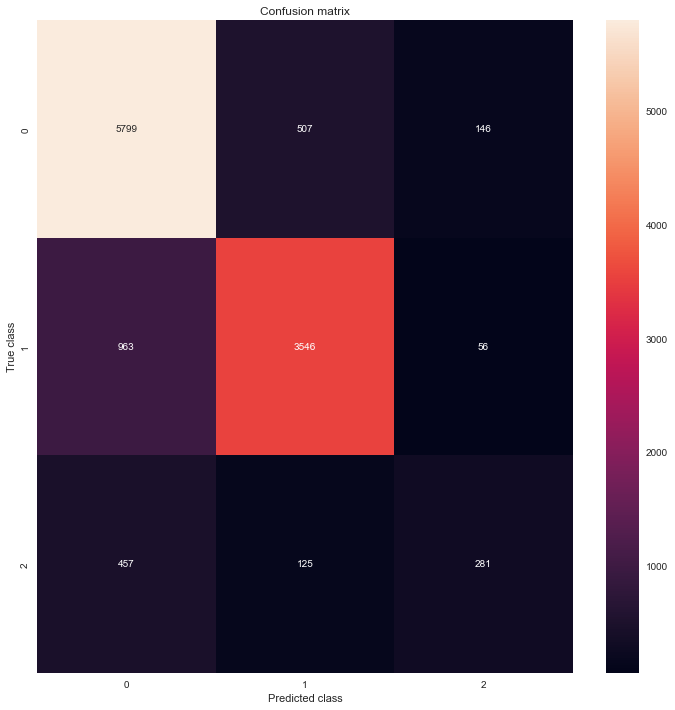

              precision    recall  f1-score   support

           0       0.80      0.90      0.85      6452
           1       0.85      0.78      0.81      4565
           2       0.58      0.33      0.42       863

    accuracy                           0.81     11880
   macro avg       0.74      0.67      0.69     11880
weighted avg       0.80      0.81      0.80     11880



In [178]:
mostrar_resultados(ytest, ypredict)

## **PRIMERA PREDICCIÓN**

In [179]:
y_predict_taken  = modelo_rfr.predict(df_prediccion__)

In [180]:
salida = pd.DataFrame(y_predict_taken,columns=['status_group'])
primera_salida = df_prediccion__.join(salida)

primera_salida['status_group'] = primera_salida['status_group'].map(lambda x: mapeo_reverso[x])

In [181]:
primera_salida['status_group'].value_counts()

functional                 9003
non functional             5224
functional needs repair     623
Name: status_group, dtype: int64

In [182]:
envio = primera_salida[['id','status_group']]
envio['id'] = envio['id'].map(lambda x: str(x))

envio['id,status_group'] = envio['id'] + ',' + envio['status_group']
envio_dos = envio[['id,status_group']].set_index('id,status_group')

envio_dos.to_csv('./primera_vuelta.csv', sep=';')

## **SEGUNDO PREPROCESADO**

**Medicción de la variable Y**


- Se hace una copia del dataframe llamado df_completo_cat_pruebas para poder hacer manipulaciones.
- La distribución de la variable objetivo es:

mapeo_reverso = {0: 'functional',
                 1: 'non functional',
                 2: 'functional needs repair',
                 3: 'pendiente'}

*comentarios*

- Se puede ver que sólo un 7.27 % de los datos corresponden a "functional needs repair"

**(*)** Pendiente son los que aún faltan por predecir.

In [183]:
df_segundo_prepro = df_completo_cat.copy()
df_completo_cat_pruebas = df_completo_cat.copy()
df_completo_cat_pruebas = df_completo_cat_pruebas[df_completo_cat_pruebas['status_group']!=3]

In [184]:
cruce = df_completo_cat_pruebas['status_group'].value_counts(normalize=True).reset_index().rename(columns={'index': 'status_group_med'})

cruce['status_group'] = cruce['status_group'].map(lambda x: round(float(x) * 100,2) )

cruce_ = df_completo_cat_pruebas['status_group'].value_counts().reset_index().rename(columns={'index': 'status_group_med'})

salida = pd.merge(left= cruce, right= cruce_, on= 'status_group_med')

salida['status_group_med'] = salida['status_group_med'].map(lambda x: mapeo_reverso[x])

salida

,status_group_med,status_group_x,status_group_y
0,functional,54.31,32259
1,non functional,38.42,22824
2,functional needs repair,7.27,4317


**Distribución y correlación de las variables**



In [185]:
corr = df_segundo_prepro.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,public_meeting,construction_year,status_group
id,1.000,-0.007,-0.003,-0.002,0.003,-0.004,-0.002,-0.003,-0.005,0.003,-0.003,0.002
amount_tsh,-0.007,1.000,0.080,0.023,-0.056,0.005,-0.027,-0.024,0.018,0.016,0.071,-0.019
gps_height,-0.003,0.080,1.000,0.149,-0.038,0.008,-0.182,-0.171,0.134,0.036,0.658,-0.049
longitude,-0.002,0.023,0.149,1.000,-0.427,0.025,0.032,0.151,0.087,0.018,0.397,-0.032
latitude,0.003,-0.056,-0.038,-0.427,1.000,0.006,-0.218,-0.200,-0.023,0.009,-0.248,0.012
num_private,-0.004,0.005,0.008,0.025,0.006,1.000,-0.021,-0.005,0.003,0.009,0.027,-0.005
region_code,-0.002,-0.027,-0.182,0.032,-0.218,-0.021,1.000,0.680,0.095,-0.016,0.031,0.034
district_code,-0.003,-0.024,-0.171,0.151,-0.200,-0.005,0.680,1.000,0.063,0.010,0.048,0.015
population,-0.005,0.018,0.134,0.087,-0.023,0.003,0.095,0.063,1.000,0.003,0.263,-0.004
public_meeting,0.003,0.016,0.036,0.018,0.009,0.009,-0.016,0.010,0.003,1.000,0.025,-0.030


**Medicción de la asimetría de las variables**

In [186]:
df_segundo_prepro.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,public_meeting,construction_year,status_group
count,74250.000000,74250.000000,74250.000000,74250.000000,7.425000e+04,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000
mean,37124.500000,318.685704,665.667313,34.074262,-5.701771e+00,0.462330,15.265414,5.629077,180.750828,0.914532,1298.463650,1.023677
std,21434.273081,2906.762364,692.761033,6.572519,2.944969e+00,11.537879,17.508907,9.641636,471.086120,0.279579,952.349375,1.136689
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18562.250000,0.000000,0.000000,33.086819,-8.525675e+00,0.000000,5.000000,2.000000,0.000000,1.000000,0.000000,0.000000
50%,37124.500000,0.000000,364.000000,34.907475,-5.026540e+00,0.000000,12.000000,3.000000,25.000000,1.000000,1986.000000,1.000000
75%,55686.750000,20.000000,1317.000000,37.181685,-3.325058e+00,0.000000,17.000000,5.000000,215.000000,1.000000,2004.000000,2.000000
max,74249.000000,350000.000000,2777.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,1.000000,2013.000000,3.000000


In [187]:
df = df_segundo_prepro

contador = 0
datos = []
indice = []

for i in df.select_dtypes(include=np.number).columns:

    linea = []

    indice.append(i)

    valx = df.select_dtypes(include=np.number).apply(lambda x: x.skew())[contador]
    contador = contador + 1

    linea.append(valx)

    daton = abs(valx) > 1

    linea.append(daton)

    datos.append(linea)


asimentria = pd.DataFrame(datos,columns=["VALOR_ASIMETRÍA","¿ES_ASIMETRICA?"],index=indice)
asimentria = asimentria[asimentria["¿ES_ASIMETRICA?"]==True]

asimentria.sort_values(by="VALOR_ASIMETRÍA",ascending=False)


,VALOR_ASIMETRÍA,¿ES_ASIMETRICA?
num_private,91.326983,True
amount_tsh,56.370021,True
population,11.780615,True
district_code,3.961433,True
region_code,3.179454,True
public_meeting,-2.965484,True
longitude,-4.187363,True


**Eliminación de la variable 'num_private' ya que no aporta valor y no está descrita en el dataset**

In [188]:
df_segundo_prepro.drop(['num_private'], axis= 1, inplace= True)

**Se va a tramificar la variable 'date_recorded' haciendo agrupaciones por AAAA/MM, ya que el día no va aportar**

In [189]:
df_segundo_prepro['date_recorded'] = df_segundo_prepro['date_recorded'].map(lambda x: str(x)[0:5]+str(x)[-5:-3])

**Se pasan a numéricas todas las variables, antes se hace una copia del preprocesado**

In [190]:
# Copia del procesado que no vamos a manipular más. 

df_segundo_prepro_completed = df_segundo_prepro.copy()

In [191]:
# Hacer conversión a numérico de todas las categorías.

le = LabelEncoder()

df_completo = df_segundo_prepro.copy()

for i in df_completo.columns:
    
    if df_completo[i].dtype != np.number and i!='origen':
        try:
            le.fit(df_completo[i].unique())
            df_completo[i] = le.transform(df_completo[i])
        except:
            
            print(f'No se puede pasar a númericos el campo: {i}')

No se puede pasar a númericos el campo: permit


In [192]:
# Pasar a numérico de manera manual el valor del campo permit.

nombres_clave = list(set(df_completo['permit']))
valores_clave = list(range(0, len(nombres_clave)))

diccionario_mapping_permit = dict(zip(nombres_clave, valores_clave))

df_completo['permit'] = df_completo['permit'].map(lambda x: diccionario_mapping_permit[x])

df_completo['permit'].value_counts()

1    48606
0    21851
2     3793
Name: permit, dtype: int64

## **APROXIMACIÓN SEGUNDO MODELO**

In [193]:
# Hacemos una copia del df con el nombre correcto.

df_segundo_modelo =df_completo.copy()

# Filtrar por el DF de traingin y test

df_segundo_modelo = df_segundo_modelo[df_segundo_modelo['status_group']!=3]

In [194]:
#1. Instanciar el modelo

model_setup = setup(data= df_segundo_modelo, target='status_group', session_id=4)

,Description,Value
0,Session id,4
1,Target,status_group
2,Target type,Multiclass
3,Original data shape,"(59400, 40)"
4,Transformed data shape,"(59400, 40)"
5,Transformed train set shape,"(41580, 40)"
6,Transformed test set shape,"(17820, 40)"
7,Numeric features,39
8,Preprocess,True
9,Imputation type,simple


In [195]:
# Tabla comparativa.

best_models = compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:25:09
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


In [196]:
model_rf = create_model('rf')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:25:24
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8112,0.9149,0.8112,0.8053,0.8039,0.6455,0.6494
1,0.8167,0.9100,0.8167,0.8105,0.8090,0.6555,0.6600
2,0.8093,0.9071,0.8093,0.8050,0.8011,0.6399,0.6457
3,0.8191,0.9122,0.8191,0.8133,0.8116,0.6601,0.6643
4,0.8119,0.9099,0.8119,0.8062,0.8042,0.6464,0.6504
5,0.8127,0.9110,0.8127,0.8071,0.8046,0.6471,0.6520
6,0.8172,0.9084,0.8172,0.8121,0.8109,0.6578,0.6615
7,0.8069,0.9004,0.8069,0.8020,0.8000,0.6373,0.6416
8,0.8054,0.9047,0.8054,0.7986,0.7974,0.6343,0.6384


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

**Se paración en Training y Test**

In [197]:
# Separación training y test

Xtrain, Xtest , ytrain, ytest = train_test_split(df_segundo_modelo.drop(['status_group'], axis=1), df_segundo_modelo['status_group'], random_state=42, test_size=0.2, stratify=df_segundo_modelo['status_group'])

## **BALANCEO DE LA MUESTRA**

In [198]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)

In [199]:
bbc.fit(Xtrain, ytrain)

BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                class_weight=None,
                                                                criterion='gini',
                                                                max_depth=None,
                                                                max_features=None,
                                                                max_leaf_nodes=None,
                                                                min_impurity_decrease=0.0,
                                                                min_samples_leaf=1,
                                                                min_samples_split=2,
                                                                min_weight_fraction_leaf=0.0,
                                                                random_state=None,
                                                                splitter='best'),
                          bootstrap=True, bootstrap_features=False,
                          estimator=None, max_features=1.0, max_samples=1.0,
                          n_estimators=10, n_jobs=None, oob_score=False,
                          random_state=0, replacement=False, sampler=None,
                          sampling_strategy='auto', verbose=0,
                          warm_start=False)

In [200]:
pred_y = bbc.predict(Xtest)

In [201]:
print(classification_report(ytest, pred_y))

              precision    recall  f1-score   support

           0       0.80      0.75      0.78      6452
           1       0.81      0.72      0.76      4565
           2       0.30      0.62      0.41       863

    accuracy                           0.73     11880
   macro avg       0.64      0.70      0.65     11880
weighted avg       0.77      0.73      0.74     11880



## **SEGUNDA PREDICCIÓN**

In [202]:

df_x_predecir = df_completo[df_completo['status_group']==3]
df_x_predecir.drop(['status_group'], axis=1, inplace= True)

y_segunda_prediccion = bbc.predict(df_x_predecir)

**Unificación del DF**

In [203]:
df_prr = pd.DataFrame(y_segunda_prediccion, columns=['status_group'])
segunda_s = df_x_predecir.join(df_prr)

In [204]:
# Función para exportar el modelo

def exportar_modelos_formateados(df_xuy, nombre_fichero = str):
    
    # Diccionario para mapear el resultado.
    
    mapeo_reverso = {0: 'functional',
                 1: 'non functional',
                 2: 'functional needs repair',
                 3: 'pendiente'}
    
    # Mapear el resultado.
    
    df_xuy['status_group'] = df_xuy['status_group'].map(lambda x: mapeo_reverso[x])
    
    # Ajuste con las columnas a reportar.
    
    envio = df_xuy[['id','status_group']]
    
    # Pasar a string el valor del ID.
    
    envio['id'] = envio['id'].map(lambda x: str(x))

    # Creación del DF
    envio['id,status_group'] = envio['id'] + ',' + envio['status_group']
    envio_dos = envio[['id,status_group']].set_index('id,status_group')

    # Reporte
    envio_dos.to_csv('./' + nombre_fichero + '.csv', sep=';')
    
    print('Proceso finalizado.')

In [205]:
exportar_modelos_formateados(segunda_s, 'segunda_predict')

Proceso finalizado.


## **TERCERA PREDICCIÓN**

**Pruebas de balance**

- En este caso, no se van a realizar preprocesos y se van a usar los dataframen numéricos ya preprocesados en la segunda predicción.
- Se van a utilizar diferentes pruebas de balanceo de la muestra.
- Se usa la 3strategia: Penalización para compensar

In [206]:
# Copia del dataframe numérico. En este caso no va a haber nuevos preprocesados.

df_tercer_modelo = df_completo.copy()

# DF para training, test y DF a predecir.

df_tercer_modelo_training_test = df_tercer_modelo[df_tercer_modelo['status_group']!=3]
df_tercer_modelo_predecir = df_tercer_modelo[df_tercer_modelo['status_group']==3]
df_tercer_modelo_predecir.drop(['status_group'], axis=1, inplace= True)

In [207]:
# Separación training y test

Xtrain, Xtest , ytrain, ytest = train_test_split(df_tercer_modelo_training_test.drop(['status_group'], axis=1), df_tercer_modelo_training_test['status_group'], random_state=42, test_size=0.2, stratify=df_tercer_modelo_training_test['status_group'])

## **Estrategia: Penalización para compensar**

In [208]:
from sklearn.linear_model import LogisticRegression

def run_model_balanced(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced")
    clf.fit(X_train, y_train)
    return clf
 


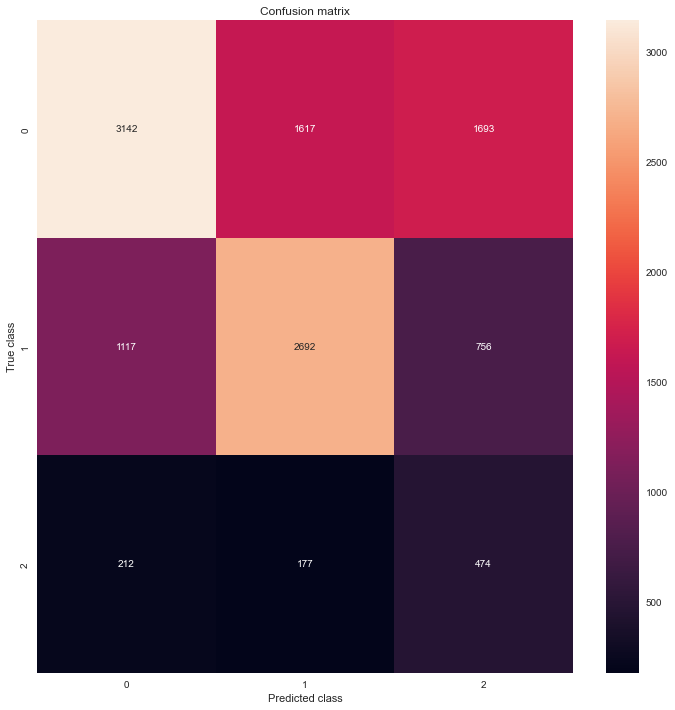

              precision    recall  f1-score   support

           0       0.70      0.49      0.58      6452
           1       0.60      0.59      0.59      4565
           2       0.16      0.55      0.25       863

    accuracy                           0.53     11880
   macro avg       0.49      0.54      0.47     11880
weighted avg       0.62      0.53      0.56     11880



In [209]:
# Modelo de penalización

model = run_model_balanced(Xtrain, Xtest , ytrain, ytest)
pred_y = model.predict(Xtest)
mostrar_resultados(ytest, pred_y)

**Ejecutar Tercer modelo**

In [210]:
# se predicen los datos con este nuevo modelo, aunque ya sambemos que los resultados no van a ser buenos.

tercer_y = model.predict(df_tercer_modelo_predecir)

y_predect_tres = pd.DataFrame(tercer_y, columns=['status_group'])

In [211]:
tercera_salida = df_tercer_modelo_predecir.join(y_predect_tres)

In [212]:
exportar_modelos_formateados(tercera_salida, 'tercera_predict')

Proceso finalizado.


## **CUARTA PREDICCIÓN**

## **Estrategia: Subsampling en la clase mayoritaria**

In [213]:
# Copia del dataframe numérico. En este caso no va a haber nuevos preprocesados.

df_cuarto_modelo = df_completo.copy()

# DF para training, test y DF a predecir.

df_cuarto_modelo_training_test = df_cuarto_modelo[df_cuarto_modelo['status_group']!=3]
df_cuarto_modelo_predecir = df_cuarto_modelo[df_cuarto_modelo['status_group']==3]
df_cuarto_modelo_predecir.drop(['status_group'], axis=1, inplace= True)

In [214]:
# Separación training y test

Xtrain, Xtest , ytrain, ytest = train_test_split(df_cuarto_modelo_training_test.drop(['status_group'], axis=1), df_cuarto_modelo_training_test['status_group'], random_state=42, test_size=0.2, stratify=df_cuarto_modelo_training_test['status_group'])

In [215]:
from imblearn.under_sampling import NearMiss

us = NearMiss(n_neighbors=3)

X_train_res, y_train_res = us.fit_resample(Xtrain, ytrain)

**Ahora con la reduccin de las variables vamos a tirar un modelo randomforest**

In [216]:
modelo_cuarto = RandomForestClassifier()

modelo_cuarto.fit(X_train_res, y_train_res)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

**Predecir test**

In [217]:
ypredict_x = modelo_cuarto.predict(Xtest)

**Resultado test**

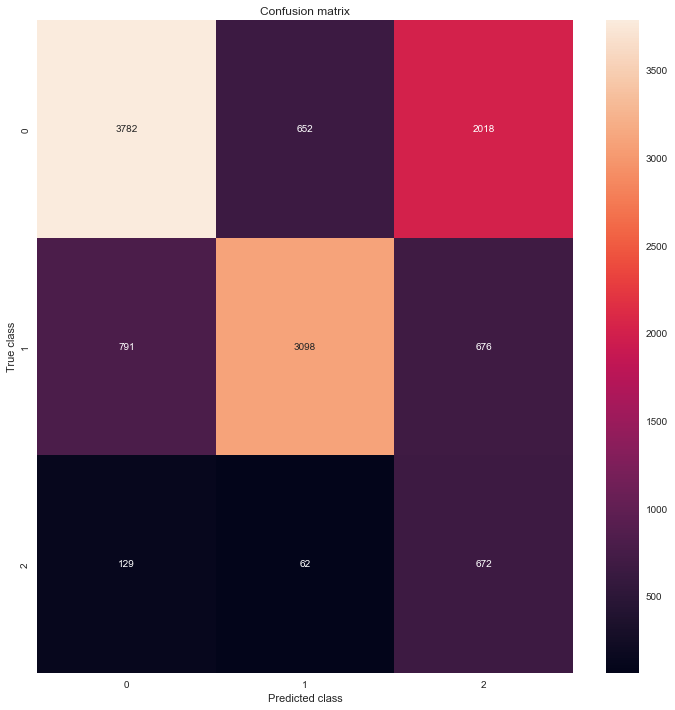

              precision    recall  f1-score   support

           0       0.80      0.59      0.68      6452
           1       0.81      0.68      0.74      4565
           2       0.20      0.78      0.32       863

    accuracy                           0.64     11880
   macro avg       0.61      0.68      0.58     11880
weighted avg       0.76      0.64      0.68     11880



In [218]:
mostrar_resultados(ytest, ypredict_x)

## **CUARTA PREDICCIÓN**

In [219]:
salida_cuarta = modelo_cuarto.predict(df_cuarto_modelo_predecir)

y_predect_cuatro = pd.DataFrame(salida_cuarta, columns=['status_group'])

In [220]:
cuarta_salida = df_cuarto_modelo_predecir.join(y_predect_cuatro)

In [221]:
exportar_modelos_formateados(cuarta_salida, 'cuarta_predict')

Proceso finalizado.


In [222]:
df_completo

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,14,1548,1450,1706,34.938093,-9.856322,45683,1,...,6,2,1,1,8,6,0,1,1,0
1,8776,0.0,30,522,1459,610,34.698766,-2.147466,45426,4,...,6,2,2,2,5,3,1,1,1,0
2,34310,25.0,29,924,746,2296,37.460664,-3.821329,17767,5,...,6,2,1,1,0,1,1,2,1,0
3,67743,0.0,28,1961,323,2078,38.486161,-11.155298,45537,7,...,6,2,0,0,3,0,0,2,1,1
4,19728,0.0,18,20,60,133,31.130847,-1.825359,43411,4,...,6,2,3,3,5,3,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,39307,0.0,13,293,94,456,38.852669,-6.582841,30976,8,...,6,2,1,1,6,4,1,1,1,3
14846,18990,1000.0,14,584,60,675,37.451633,-5.350428,1352,5,...,4,4,2,2,7,5,0,4,3,3
14847,28749,0.0,30,2140,1536,2395,34.739804,-4.585587,1821,0,...,6,2,2,2,0,1,1,1,1,3
14848,33492,0.0,29,482,1058,442,35.432732,-10.584159,14467,1,...,6,2,2,2,6,4,1,1,1,3


## **QUINTA PREDICCIÓN**

**Copias de los DF**

In [223]:
# Copia del DF preprocesado.

quinta_prediccion_pp = df_segundo_prepro_completed

# Copia del DF pasado a variables continuas.

quinta_predicion_num = df_completo

**Separación training y test**

In [224]:
# Eliminación de la parte del DF a predecir.

quinta_predicion_num_t = quinta_predicion_num[quinta_predicion_num['status_group']!=3]

In [225]:
# Separación training y test

Xtrain, Xtest , ytrain, ytest = train_test_split(quinta_predicion_num_t.drop(['status_group'], axis=1), quinta_predicion_num_t['status_group'], random_state=42, test_size=0.2, stratify=quinta_predicion_num_t['status_group'])

**Oversampling**

In [226]:
oversample = SMOTE()
Xtrain_ , ytrain_ = oversample.fit_resample(Xtrain, ytrain)

In [227]:
# Hemos hecho una resample de cada clase para que haya el mismo número.

Counter(ytrain_)

Counter({1: 25807, 2: 25807, 0: 25807})

## **Nuevo PYCARET con del modelo oversampling**

In [228]:
quinto_oversampling = Xtrain_.join(ytrain_)

In [229]:
#1. Instanciar el modelo

model_setup = setup(data= quinto_oversampling, target='status_group', session_id=4)

,Description,Value
0,Session id,4
1,Target,status_group
2,Target type,Multiclass
3,Original data shape,"(77421, 40)"
4,Transformed data shape,"(77421, 40)"
5,Transformed train set shape,"(54194, 40)"
6,Transformed test set shape,"(23227, 40)"
7,Numeric features,39
8,Preprocess,True
9,Imputation type,simple


In [230]:
# Tabla comparativa.

best_models = compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:26:01
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


In [231]:
model_rf = create_model('rf')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:26:18
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8443,0.9558,0.8443,0.8459,0.8435,0.7664,0.7678
1,0.8450,0.9535,0.8450,0.8465,0.8439,0.7675,0.7692
2,0.8434,0.9543,0.8434,0.8446,0.8424,0.7650,0.7664
3,0.8461,0.9513,0.8461,0.8484,0.8452,0.7692,0.7710
4,0.8443,0.9514,0.8443,0.8454,0.8434,0.7664,0.7677
5,0.8382,0.9511,0.8382,0.8394,0.8370,0.7572,0.7588
6,0.8562,0.9554,0.8562,0.8574,0.8551,0.7844,0.7859
7,0.8424,0.9549,0.8424,0.8434,0.8416,0.7636,0.7648
8,0.8430,0.9518,0.8430,0.8451,0.8418,0.7644,0.7664


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

## **Modelo QUINTO**

In [232]:
# Ejecutamos un primer modelo utilizando la extracción del pycarest

from sklearn.ensemble import RandomForestClassifier

modelo_rfr = RandomForestClassifier()


In [233]:
# Partición Training & Test

Xtrain, Xtest , ytrain, ytest = train_test_split(quinto_oversampling.drop(['status_group'], axis=1), quinto_oversampling['status_group'], random_state=42, test_size=0.2, stratify=quinto_oversampling['status_group'])

In [234]:
# Entrenamiento del modelo.

modelo_rfr.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [235]:
# Predecir test

ypredict  = modelo_rfr.predict(Xtest)

In [236]:
# Comparativa del modelo de la predicción y del test

print(classification_report(ytest, ypredict))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      5161
           1       0.86      0.77      0.81      5162
           2       0.88      0.91      0.89      5162

    accuracy                           0.85     15485
   macro avg       0.85      0.85      0.85     15485
weighted avg       0.85      0.85      0.85     15485



**Predicción**

In [237]:
# X a predecir.

x_predeccir = quinta_predicion_num[quinta_predicion_num['status_group']==3]

x_predeccir.drop(['status_group'], axis= 1, inplace= True)

In [238]:
# Predicción

solucion_quinta = modelo_rfr.predict(x_predeccir)

In [239]:
# df
y_predect_quinto = pd.DataFrame(solucion_quinta, columns=['status_group'])

# Unión completa

quinta_salida = x_predeccir.join(y_predect_quinto)

In [240]:
# Exportar

exportar_modelos_formateados(quinta_salida, 'quinta_predict')

Proceso finalizado.


## **Modelo SEXTO**

**Copia de los DF**

In [241]:
# Copia de los DF

sexta_prediccion_pp = df_segundo_prepro_completed

# Copia del DF pasado a variables continuas.

sexta_predicion_num = df_completo

**Revisión del preprocesado**

- Revisión de las variables missing. Se va a hacer una prueba eliminando las variables.

    - Scheme name: Se va eliminar la variable. Correlación con la variable objetivo (0.010)
    - scheme_management: Se va eliminar la variable. Correlación con la variable objetivo (0.002)
    - installer: Se va eliminar la variable. Correlación con la variable objetivo (-0.008)
    - Funder: Se va eliminar la variable. Correlación con la variable objetivo (-0.010)
    - subvillage: Se va eliminar la variable. Correlación con la variable objetivo  (-0.004)

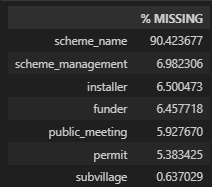

**Tabla de correlación**

In [242]:
corr = sexta_predicion_num.corr()
salida = corr.style.background_gradient(cmap='coolwarm').format(precision=3)
salida

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,1.000,-0.007,0.008,-0.007,-0.003,-0.003,-0.002,0.003,-0.002,-0.003,-0.004,-0.001,0.001,-0.000,0.000,-0.005,0.001,0.003,nan,-0.006,0.002,-0.001,-0.004,-0.002,-0.002,-0.002,-0.004,-0.003,-0.003,-0.001,-0.001,0.004,0.003,0.003,-0.004,-0.004,-0.004,-0.002,-0.004,0.002
amount_tsh,-0.007,1.000,-0.016,0.001,0.080,0.006,0.023,-0.056,0.015,0.013,0.000,-0.021,-0.029,-0.035,0.012,0.001,0.037,0.016,nan,-0.015,-0.020,0.017,0.065,-0.023,-0.015,-0.010,-0.010,-0.002,0.014,-0.124,0.013,-0.024,-0.016,-0.016,-0.001,-0.003,0.037,-0.046,-0.044,-0.019
date_recorded,0.008,-0.016,1.000,-0.019,0.262,-0.016,-0.054,0.265,-0.116,-0.224,0.058,-0.018,0.130,-0.034,0.053,0.070,0.174,-0.021,nan,0.102,-0.046,0.083,0.209,-0.038,-0.065,0.000,0.058,-0.055,0.213,0.261,0.011,0.021,0.038,0.038,-0.034,-0.043,-0.045,0.046,0.033,0.014
funder,-0.007,0.001,-0.019,1.000,-0.028,0.626,-0.031,-0.005,-0.009,-0.175,-0.021,0.153,0.050,-0.004,0.062,0.003,-0.057,-0.018,nan,-0.001,0.059,0.127,-0.079,-0.029,-0.021,0.021,0.043,-0.016,0.040,0.064,-0.018,0.042,0.068,0.068,-0.081,-0.094,0.052,0.020,0.013,-0.010
gps_height,-0.003,0.080,0.262,-0.028,1.000,-0.009,0.149,-0.038,0.057,-0.159,0.003,-0.325,-0.150,-0.190,0.138,0.044,0.249,0.036,nan,-0.044,-0.170,0.108,0.573,-0.238,-0.262,-0.235,-0.037,0.026,0.113,-0.100,0.136,-0.090,-0.031,-0.031,0.122,0.125,0.040,-0.237,-0.216,-0.049
installer,-0.003,0.006,-0.016,0.626,-0.009,1.000,0.011,-0.033,-0.005,-0.146,-0.023,0.142,0.068,0.039,0.154,-0.007,-0.028,-0.035,nan,-0.025,0.007,0.202,-0.050,-0.015,0.002,0.045,-0.022,-0.027,-0.001,0.039,0.026,0.026,0.080,0.080,-0.089,-0.089,0.067,-0.008,-0.010,-0.008
longitude,-0.002,0.023,-0.054,-0.031,0.149,0.011,1.000,-0.427,-0.019,0.217,0.010,-0.143,-0.287,0.158,0.227,0.039,0.146,0.018,nan,-0.095,-0.131,0.100,0.351,-0.026,-0.016,0.049,-0.176,-0.081,0.017,-0.007,-0.054,-0.032,0.015,0.015,-0.014,-0.047,0.022,-0.165,-0.147,-0.032
latitude,0.003,-0.056,0.265,-0.005,-0.038,-0.033,-0.427,1.000,-0.061,-0.219,-0.007,-0.024,0.086,-0.182,-0.267,0.010,-0.046,0.009,nan,0.045,0.056,0.054,-0.202,-0.005,-0.000,0.003,0.051,-0.054,-0.042,0.147,-0.009,0.039,0.118,0.118,0.027,0.067,-0.041,0.159,0.146,0.012
wpt_name,-0.002,0.015,-0.116,-0.009,0.057,-0.005,-0.019,-0.061,1.000,-0.014,0.092,-0.045,0.030,-0.016,-0.037,0.001,0.017,-0.011,nan,-0.025,0.031,-0.057,0.013,0.004,0.001,-0.018,-0.053,-0.028,-0.049,-0.057,0.014,-0.017,0.018,0.018,0.000,-0.002,0.014,-0.026,-0.024,-0.002
basin,-0.003,0.013,-0.224,-0.175,-0.159,-0.146,0.217,-0.219,-0.014,1.000,0.061,-0.115,-0.193,0.143,-0.007,0.044,0.106,0.022,nan,-0.007,0.019,-0.088,0.229,0.169,0.192,0.180,-0.064,-0.071,-0.018,-0.030,-0.075,0.047,-0.027,-0.027,-0.061,-0.075,0.032,0.009,0.013,0.013


**Eliminación de variables**

In [243]:
lista_missing = ['scheme_name', 'scheme_management', 'installer', 'funder', 'public_meeting','recorded_by']

sexta_predicion_num.drop(lista_missing, axis = 1, inplace = True)

**Separación de variables**

In [244]:
entrenar = sexta_predicion_num[sexta_predicion_num['status_group'] != 3]
predecir = sexta_predicion_num[sexta_predicion_num['status_group'] == 3]

**Aproximación pycaret con el nuevo DF**

In [245]:
model_setup = setup(data= entrenar, target='status_group', session_id=4)

,Description,Value
0,Session id,4
1,Target,status_group
2,Target type,Multiclass
3,Original data shape,"(59400, 34)"
4,Transformed data shape,"(59400, 34)"
5,Transformed train set shape,"(41580, 34)"
6,Transformed test set shape,"(17820, 34)"
7,Numeric features,33
8,Preprocess,True
9,Imputation type,simple


In [246]:
# Tabla comparativa.

best_models = compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:26:38
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


**Se comprueba que el modelo no mejora, se va aquitar sólo  variable recorded by y se vuelve a tirar un modelo pycaret**

In [247]:
# Copia de los DF

sexta_prediccion_pap = df_segundo_prepro_completed

# Copia del DF pasado a variables continuas.

sexta_predicion_numa = df_completo

# Eliminación de variables

lista_missing = ['recorded_by']

sexta_prediccion_pap.drop(lista_missing, axis = 1, inplace = True)

# Separación

entrenar = sexta_predicion_numa[sexta_predicion_numa['status_group'] != 3]
predecir = sexta_predicion_numa[sexta_predicion_numa['status_group'] == 3]

# Creación

model_setup = setup(data= entrenar, target='status_group', session_id=4)

,Description,Value
0,Session id,4
1,Target,status_group
2,Target type,Multiclass
3,Original data shape,"(59400, 34)"
4,Transformed data shape,"(59400, 34)"
5,Transformed train set shape,"(41580, 34)"
6,Transformed test set shape,"(17820, 34)"
7,Numeric features,33
8,Preprocess,True
9,Imputation type,simple


In [248]:
# Tabla comparativa.

best_models = compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:26:52
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


In [249]:
# Creación de modelo

model_rf = create_model('rf')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:27:04
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8127,0.9119,0.8127,0.8065,0.8051,0.6480,0.6522
1,0.8119,0.9086,0.8119,0.8058,0.8046,0.6469,0.6511
2,0.8038,0.9056,0.8038,0.7976,0.7951,0.6297,0.6352
3,0.8151,0.9112,0.8151,0.8099,0.8076,0.6521,0.6567
4,0.8071,0.9082,0.8071,0.8008,0.7990,0.6372,0.6412
5,0.8098,0.9093,0.8098,0.8037,0.8014,0.6417,0.6462
6,0.8182,0.9078,0.8182,0.8134,0.8117,0.6591,0.6632
7,0.8047,0.8999,0.8047,0.7993,0.7970,0.6324,0.6370
8,0.8047,0.9028,0.8047,0.7969,0.7956,0.6320,0.6365


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [250]:
# Tuenar modelo

tune_model_rf = tune_model(model_rf)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:27:06
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7011,0.7510,0.7011,0.6597,0.6669,0.4048,0.4284
1,0.7025,0.7508,0.7025,0.6650,0.6670,0.4050,0.4334
2,0.6970,0.7387,0.6970,0.6576,0.6612,0.3943,0.4213
3,0.7059,0.7534,0.7059,0.6647,0.6723,0.4149,0.4382
4,0.7023,0.7466,0.7023,0.6632,0.6669,0.4052,0.4324
5,0.6991,0.7410,0.6991,0.6610,0.6633,0.3981,0.4263
6,0.7078,0.7590,0.7078,0.6731,0.6712,0.4139,0.4466
7,0.6994,0.7451,0.6994,0.6630,0.6635,0.3978,0.4272
8,0.6977,0.7417,0.6977,0.6608,0.6618,0.3948,0.4238


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


**Extracción de hyperparámetros**

In [251]:
print(tune_model_rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=4, verbose=0, warm_start=False)


## **Modelo con hiperparametros**

**Training and test**

In [252]:
# Partición Training & Test

Xtrain, Xtest , ytrain, ytest = train_test_split(entrenar.drop(['status_group'], axis=1), entrenar['status_group'], random_state=42, test_size=0.2, stratify=entrenar['status_group'])

**Sexto modelo**

In [253]:
sextomodelo = RandomForestClassifier(bootstrap=False, criterion='gini', max_depth=None, n_estimators=100).fit(Xtrain,ytrain)

In [254]:
ypredict = sextomodelo.predict(Xtest)

In [255]:
# Comparativa del modelo de la predicción y del test

print(classification_report(ytest, ypredict))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      6452
           1       0.83      0.79      0.81      4565
           2       0.53      0.36      0.43       863

    accuracy                           0.80     11880
   macro avg       0.72      0.67      0.69     11880
weighted avg       0.80      0.80      0.80     11880



## **Sexta Predict**

In [256]:
primera_parte = predecir.drop(['status_group'], axis= 1 )

sexta_predicción = sextomodelo.predict(primera_parte)

In [257]:
# df
y_predect_sexto = pd.DataFrame(sexta_predicción, columns=['status_group'])

# Unión completa

sexta_salida = primera_parte.join(y_predect_quinto)

In [258]:
# Exportar

exportar_modelos_formateados(sexta_salida, 'sexta_salida')

Proceso finalizado.


## **Séptimo MODELO**

**Se va a hacer un oversampling con el modelo tuneado**

- En el modelo se elimina la variable 'recorded_by'

In [259]:
# Copia de los DF

septima_prediccion_pp = df_segundo_prepro_completed

# Copia del DF pasado a variables continuas.

septima_predicion_num = df_completo

In [260]:
# Comprobación de vairables. La única variable que no tiene es recorder by

lista_missing = ['scheme_name', 'scheme_management', 'installer', 'funder', 'public_meeting','recorded_by']

for i in septima_prediccion_pp.columns:
    
    for adivina in lista_missing:
        
        if adivina == i:
            
            print(i)

funder
installer
public_meeting
scheme_management
scheme_name


**Pasar a numérico**

In [261]:
# Hacer conversión a numérico de todas las categorías.

le = LabelEncoder()

df_completo = septima_prediccion_pp.copy()

for i in df_completo.columns:
    
    if df_completo[i].dtype != np.number and i!='origen':
        try:
            le.fit(df_completo[i].unique())
            df_completo[i] = le.transform(df_completo[i])
        except:
            
            print(f'No se puede pasar a númericos el campo: {i}')

No se puede pasar a númericos el campo: permit


In [262]:
# Pasar a numérico de manera manual el valor del campo permit.

nombres_clave = list(set(df_completo['permit']))
valores_clave = list(range(0, len(nombres_clave)))

diccionario_mapping_permit = dict(zip(nombres_clave, valores_clave))

df_completo['permit'] = df_completo['permit'].map(lambda x: diccionario_mapping_permit[x])

df_completo['permit'].value_counts()

1    48606
0    21851
2     3793
Name: permit, dtype: int64

**Separación del df en training/test y a predecir**

In [263]:
df_septimo_modeler = df_completo[df_completo['status_group'] != 3]
df_septimo_predict = df_completo[df_completo['status_group'] == 3]

# Comprobar

if df_septimo_modeler.shape[0] + df_septimo_predict.shape[0] == df_completo.shape[0]:
    print('La sepración contiene los mismos registros.')

else:
    print('La sepración no contiene los mismos registros.')

La sepración contiene los mismos registros.


**Realización oversampling**

In [264]:
oversample = SMOTE()

Xtrain_ , ytrain_ = oversample.fit_resample(df_septimo_modeler.drop(['status_group'], axis=1), df_septimo_modeler['status_group'])

df_septimo_modeler_oversampling = Xtrain_.join(ytrain_)



**Comprobación del oversampling**


In [265]:
print(Counter(df_septimo_modeler['status_group']))
print('-')
print(Counter(ytrain_))

Counter({0: 32259, 1: 22824, 2: 4317})
-
Counter({0: 32259, 1: 32259, 2: 32259})


**Comprobación pycaret**

In [266]:
# Creación

model_setup = setup(data= df_septimo_modeler_oversampling.drop(['id'], axis=1), target='status_group', session_id=4)

In [267]:
# Tabla comparativa.

best_models = compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:27:30
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


In [268]:
# Creación modelo.

model_rf = create_model('rf')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:27:54
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8424,0.9546,0.8424,0.8437,0.8416,0.7635,0.7648
1,0.8462,0.9531,0.8462,0.8476,0.8458,0.7693,0.7703
2,0.8430,0.9535,0.8430,0.8443,0.8420,0.7644,0.7659
3,0.8465,0.9526,0.8465,0.8476,0.8455,0.7697,0.7711
4,0.8444,0.9555,0.8444,0.8452,0.8437,0.7666,0.7676
5,0.8512,0.9534,0.8512,0.8523,0.8503,0.7768,0.7780
6,0.8438,0.9532,0.8438,0.8450,0.8430,0.7657,0.7670
7,0.8477,0.9535,0.8477,0.8483,0.8470,0.7715,0.7723
8,0.8471,0.9544,0.8471,0.8484,0.8462,0.7706,0.7720


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [269]:
tune_model_rf = tune_model(model_rf)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:27:57
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7414,0.9025,0.7414,0.7594,0.7375,0.6121,0.6217
1,0.7479,0.9036,0.7479,0.7668,0.7438,0.6218,0.6316
2,0.7452,0.8995,0.7452,0.7673,0.7403,0.6179,0.6291
3,0.7520,0.9025,0.7520,0.7696,0.7467,0.6280,0.6384
4,0.7532,0.9080,0.7532,0.7757,0.7477,0.6298,0.6418
5,0.7495,0.9021,0.7495,0.7694,0.7450,0.6242,0.6346
6,0.7430,0.9032,0.7430,0.7644,0.7385,0.6145,0.6253
7,0.7536,0.9054,0.7536,0.7703,0.7496,0.6304,0.6394
8,0.7471,0.9018,0.7471,0.7654,0.7416,0.6207,0.6313


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [270]:
print(tune_model_rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=4, verbose=0, warm_start=False)


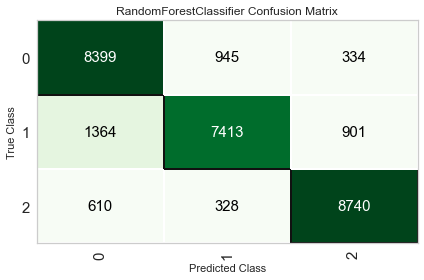

In [271]:
plot_model(tune_model_rf, plot='confusion_matrix')

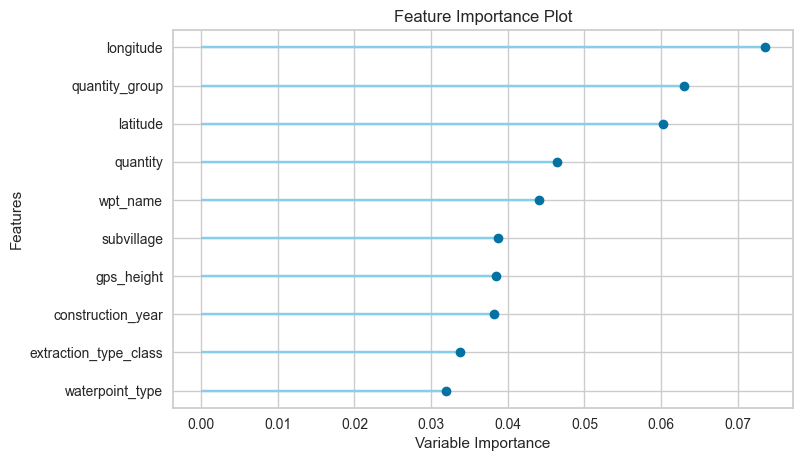

In [272]:
plot_model(tune_model_rf, plot='feature')

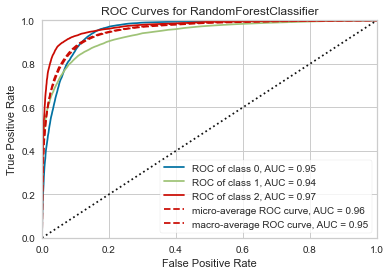

In [273]:
plot_model(tune_model_rf, plot='auc')

**Creación de modelo**

In [274]:
# Partición Training & Test

Xtrain, Xtest , ytrain, ytest = train_test_split(df_septimo_modeler_oversampling.drop(['status_group', 'id'], axis=1), df_septimo_modeler_oversampling['status_group'], random_state=42, test_size=0.2, stratify=df_septimo_modeler_oversampling['status_group'])

In [275]:
# Entrenar el modelo sin hiperparametros

#bootstrap=False, criterion='gini', max_depth=None, n_estimators=100

septomodelo = RandomForestClassifier().fit(Xtrain, ytrain)

In [276]:
# Predeicr

ypredecida = septomodelo.predict(Xtest)


In [277]:
# Comparativa del modelo de la predicción y del test

print(classification_report(ytest, ypredecida))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      6452
           1       0.86      0.77      0.81      6452
           2       0.88      0.90      0.89      6452

    accuracy                           0.85     19356
   macro avg       0.85      0.85      0.85     19356
weighted avg       0.85      0.85      0.85     19356



**Realizar predicción sin hiperparametros.**

In [278]:
ypredecida_model_no_tunner = septomodelo.predict(df_septimo_predict.drop(['id','status_group'], axis= 1))

In [279]:
y_predect_sep = pd.DataFrame(ypredecida_model_no_tunner, columns=['status_group'])

# Unión completa

septima_salida = df_septimo_predict[['id']].join(y_predect_sep)


In [280]:
exportar_modelos_formateados(septima_salida, 'septima_salida')

Proceso finalizado.


**Modelo con hiperparametros**

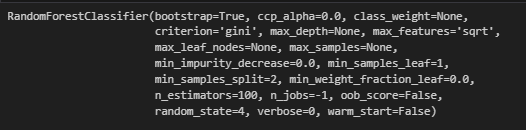

In [281]:
septomodelo_tuner = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=None, n_estimators=100).fit(Xtrain, ytrain)

In [282]:
y_sep_modeler_tunn = septomodelo_tuner.predict(df_septimo_predict.drop(['id','status_group'], axis= 1))

In [283]:
y_predect_sep = pd.DataFrame(y_sep_modeler_tunn, columns=['status_group'])

# Unión completa

septima_salida_plus = df_septimo_predict[['id']].join(y_predect_sep)


In [284]:
exportar_modelos_formateados(septima_salida_plus, 'septima_salida_plus')

Proceso finalizado.


## **Último modelo**

- Modelo completo
- Oversampling
- Prueba con hiperparametros y sin ellos


In [285]:
# Se hace un copiado del DF completo, sin eliminar ninguna variable y con todas ellas transformadas de categóricas a continuas.

last_predect_num = df_prepro_done

**Comprobación que tiene todas las variables**

In [286]:
# Comprobación de vairables. Comprobar que nuestro DF está completo, para ello, se comprueban las que se quitaron en el punto 6. 

lista_missing = ['scheme_name', 'scheme_management', 'installer', 'funder', 'public_meeting','recorded_by']

for i in last_predect_num.columns:
    
    for adivina in lista_missing:
        
        if adivina == i:
            
            print(i)

funder
installer
public_meeting
recorded_by
scheme_management
scheme_name


**Separación del DF completo preprocesado para el entrenamiento y también para los datos a predecir**

In [287]:
# Separación del DF, entrenamiento y el fichero a predecir

las_modell_to_fit = last_predect_num[last_predect_num['status_group'] != 3]
las_modell_to_predict = last_predect_num[last_predect_num['status_group'] == 3]

# Comprobar

if las_modell_to_fit.shape[0] + las_modell_to_predict.shape[0] == last_predect_num.shape[0]:
    
    print('La sepración contiene los mismos registros.')

else:
    print('La sepración no contiene los mismos registros.')

La sepración contiene los mismos registros.


**Oversampling de la variable**

In [290]:
oversample = SMOTE()

Xtrain_ , ytrain_ = oversample.fit_resample(las_modell_to_fit.drop(['status_group'], axis=1), las_modell_to_fit['status_group'])

last_modell_oversampled = Xtrain_.join(ytrain_)


**Comprobación de la variable objetivo**

In [299]:
# Variables posibles antes de hacer el oversampling.

busqueda = list(set(las_modell_to_fit['status_group']))

# Identificación de los dos DF (antes de hacer el oversampling y después)

df_before_oversampling = las_modell_to_fit
df_afeter_oversampling = last_modell_oversampled

# Variable objetivo

target = 'status_group'

# Ejercicio de identificación

for i in busqueda:
    
    bef = int(df_before_oversampling[df_before_oversampling[target]==i].shape[0])
    aft = int(df_afeter_oversampling[df_afeter_oversampling[target]==i].shape[0])
    
    try:
        
        valor = str(round(((aft-bef) / bef)*100,2)) + ' %'
    
    except:
        
        valor = '0%'
    
    print(f'--> La varibale {i} tenía una frecuencia de {bef} antes del oversampling, después del oversampling su frecuencia es {aft}. Esta variable ha aumentado en {valor}.')

--> La varibale 0 tenía una frecuencia de 32259 antes del oversampling, después del oversampling su frecuencia es 32259. Esta variable ha aumentado en 0.0 %.
--> La varibale 1 tenía una frecuencia de 22824 antes del oversampling, después del oversampling su frecuencia es 32259. Esta variable ha aumentado en 41.34 %.
--> La varibale 2 tenía una frecuencia de 4317 antes del oversampling, después del oversampling su frecuencia es 32259. Esta variable ha aumentado en 647.26 %.


**Modelo en pycaret**

In [305]:
# Creación

model_setup = setup(data= last_modell_oversampled, target='status_group', session_id=4)

**Creación modelo**

In [306]:
# Tabla comparativa.

best_models = compare_models()


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:02:49
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


**Idnetificación modelo**

In [307]:
best_models

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=4, verbose=0, warm_start=False)

**Compración modelo**

In [311]:
# Creación modelo.

model_rf_ = create_model('rf')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:18:11
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8497,0.9560,0.8497,0.8522,0.8489,0.7746,0.7765
1,0.8400,0.9536,0.8400,0.8410,0.8393,0.7600,0.7611
2,0.8453,0.9539,0.8453,0.8467,0.8447,0.7680,0.7692
3,0.8527,0.9550,0.8527,0.8539,0.8519,0.7790,0.7802
4,0.8471,0.9565,0.8471,0.8484,0.8461,0.7706,0.7720
5,0.8503,0.9540,0.8503,0.8513,0.8494,0.7755,0.7767
6,0.8487,0.9553,0.8487,0.8506,0.8475,0.7730,0.7749
7,0.8437,0.9540,0.8437,0.8446,0.8428,0.7655,0.7666
8,0.8493,0.9553,0.8493,0.8507,0.8485,0.7739,0.7752


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

**Tunera modelo**

In [312]:
tune_model_rf = tune_model(model_rf_)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:18:17
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7495,0.9025,0.7495,0.7721,0.7445,0.6243,0.6361
1,0.7444,0.8985,0.7444,0.7642,0.7400,0.6165,0.6269
2,0.7452,0.9003,0.7452,0.7657,0.7401,0.6179,0.6287
3,0.7510,0.9068,0.7510,0.7713,0.7452,0.6264,0.6377
4,0.7570,0.9071,0.7570,0.7773,0.7516,0.6355,0.6466
5,0.7563,0.9056,0.7563,0.7746,0.7515,0.6344,0.6442
6,0.7437,0.9041,0.7437,0.7658,0.7380,0.6156,0.6275
7,0.7490,0.9040,0.7490,0.7671,0.7443,0.6236,0.6332
8,0.7530,0.9038,0.7530,0.7689,0.7484,0.6295,0.6387


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


**Identificación de hiperparámetros**

In [320]:
salida = tune_model_rf
salida

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=4, verbose=0, warm_start=False)

## **Modelo sin hiperparámetros**

**Sepración training & test**

In [315]:
# Partición Training & Test

Xtrain, Xtest , ytrain, ytest = train_test_split(last_modell_oversampled.drop(['status_group'], axis=1), last_modell_oversampled['status_group'], random_state=42, test_size=0.2, stratify=last_modell_oversampled['status_group'])

**Modelo sin hiperparamtros**

In [317]:
last_model_without_hp = RandomForestClassifier().fit(Xtrain, ytrain)

**Predicción sobre el test**

In [318]:
ypredictible = last_model_without_hp.predict(Xtest)

**Comparar resultados con el test**

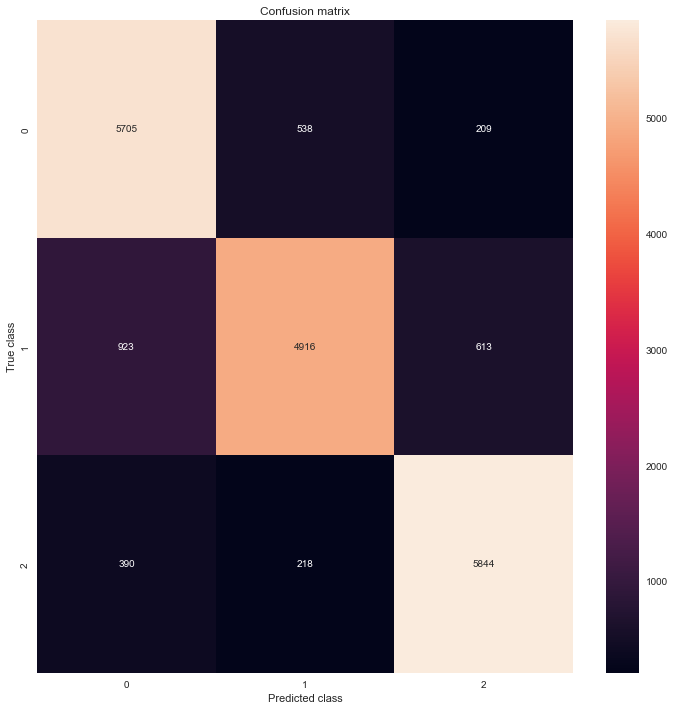

              precision    recall  f1-score   support

           0       0.81      0.88      0.85      6452
           1       0.87      0.76      0.81      6452
           2       0.88      0.91      0.89      6452

    accuracy                           0.85     19356
   macro avg       0.85      0.85      0.85     19356
weighted avg       0.85      0.85      0.85     19356



In [319]:
mostrar_resultados(ytest, ypredictible)

**Predecir datos objetivos**

In [321]:
redo = last_model_without_hp.predict(las_modell_to_predict.drop(['status_group'], axis= 1))

In [325]:
last_withouth_hp = pd.DataFrame(redo, columns=['status_group'])

# Unión completa

last_withouth_hp_salida = las_modell_to_predict[['id']].join(last_withouth_hp)

In [327]:
exportar_modelos_formateados(last_withouth_hp_salida, 'last_without_hp')

Proceso finalizado.


## **Modelo con hiperparámetros**

In [334]:
last_model_hp = RandomForestClassifier(
    bootstrap= True,
    ccp_alpha=0.0,
    class_weight= None,
    criterion= 'gini',
    max_depth= None,
    max_features='sqrt',
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    n_estimators=100,
    n_jobs=1,
    oob_score=False,
    random_state=4,
    verbose=0,
    warm_start=False).fit(Xtrain, ytrain)

**Prediccción con el nuevo modelo**

In [335]:
redo_dos = last_model_hp.predict(las_modell_to_predict.drop(['status_group'], axis= 1))

In [337]:
last_hp = pd.DataFrame(redo_dos, columns=['status_group'])

# Unión completa

last_hp_salida = las_modell_to_predict[['id']].join(last_hp)

In [338]:
exportar_modelos_formateados(last_hp_salida, 'last_hp')

Proceso finalizado.


#                                             **FIN**